In [ ]:
import os
import pandas as pd
import gcsfs
from google.oauth2.service_account import Credentials
from pyspark.sql import SparkSession
import numpy as np 


In [ ]:
os.environ["JAVA_HOME"] = "/Library/Java/JavaVirtualMachines/jdk-20.jdk/Contents/Home"
print(os.environ['JAVA_HOME'])

In [ ]:
spark = SparkSession.builder \
    .appName('energy_prediction') \
    .config('spark.jars.packages', 'com.google.cloud.bigdataoss:gcs-connector:hadoop3-2.0.1') \
    .getOrCreate()

In [ ]:
spark._jsc.hadoopConfiguration().set("google.cloud.auth.service.account.json.keyfile","./config/credentials.json")
spark._jsc.hadoopConfiguration().set("fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem")
spark._jsc.hadoopConfiguration().set("fs.AbstractFileSystem.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS")

In [ ]:
# spark.stop()

In [ ]:
bucket_name="walkingbucket"
path=f"gs://{bucket_name}/ashrae-energy-prediction/weather_test.csv"
df=spark.read.csv(path, header=True)
df.show()

Alternative approach.

In [11]:
# Path to your service account key file
key_file_path = './config/credentials.json'

# Create credentials with the appropriate scope
credentials = Credentials.from_service_account_file(key_file_path, 
    scopes=['https://www.googleapis.com/auth/devstorage.read_write'])

In [12]:
# Create a GCSFileSystem object using these credentials
gcs = gcsfs.GCSFileSystem(token=credentials)

In [21]:
# if files small:
files = gcs.ls('walkingbucket/ashrae-energy-prediction/')
csv_files = [file for file in files if file.endswith('.csv')]
dfs = [pd.read_csv(gcs.open(file)) for file in csv_files]

In [23]:
len(dfs)

5

In [38]:
dfs_dict = {
    'building_metadata': dfs[0],
    'test': dfs[1],
    'train': dfs[2],
    'weather_test': dfs[3],
    'weather_train': dfs[4]
}

In [36]:
print('Size of train data', train.shape)
print('Size of test data', test.shape)
print('Size of weather_train data', weather_train.shape)
print('Size of weather_test data', weather_test.shape)
print('Size of building_meta data', building_metadata.shape)

Size of train data (20216100, 4)
Size of test data (41697600, 4)
Size of weather_train data (139773, 9)
Size of weather_test data (277243, 9)
Size of building_meta data (1449, 6)


In [37]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [39]:
for key, df in dfs_dict.items():
    dfs_dict[key] = reduce_mem_usage(df)

Mem. usage decreased to  0.03 Mb (60.3% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)


In [40]:
train = dfs_dict['train']
test = dfs_dict['test']
weather_train = dfs_dict['weather_train']
weather_test = dfs_dict['weather_test']
building_metadata = dfs_dict['building_metadata']

In [47]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [49]:
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609


In [51]:
building_metadata.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [52]:
# merge datasets 
train = train.merge(building_metadata, on='building_id', how='left')
test = test.merge(building_metadata, on='building_id', how='left')

train = train.merge(weather_train, on=['site_id', 'timestamp'], how='left')
test = test.merge(weather_test, on=['site_id', 'timestamp'], how='left')

In [57]:
train.shape

(20216100, 16)

## Exploratory Data Analysis

Steps
- data types
- missing data 
- distribution meter: type of meters, meter reading per type, meter reading over time
- distribution building: building use, floor count, year built, square footage 
- distribution weather: site air temp  
- correlations

In [53]:
import seaborn as sns
import pandas as pd
import missingno as msno
%matplotlib inline

In [64]:
tdfs = train.sample(1000000)
tdfs.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed'],
      dtype='object')

In [67]:
tdfs.describe()

,building_id,meter,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1000000.00000,400334.0,173515.0,995263.000000,563091.0,995096.000000,814864.0,938894.0,928572.0,993007.000000
mean,798.546255,0.660888,2.213647e+03,7.984463,107541.66640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,427.045313,0.929707,1.562718e+05,5.100167,116963.78875,NaN,0.0,0.000000,0.0,0.000000,NaN,NaN,NaN,0.000000
min,0.000000,0.000000,0.000000e+00,0.000000,283.00000,1900.0,1.0,-28.906250,0.0,-35.000000,-1.0,968.0,0.0,0.000000
25%,391.000000,0.000000,1.830000e+01,3.000000,32256.00000,1951.0,1.0,8.601562,0.0,0.000000,0.0,1011.5,80.0,2.099609
50%,894.000000,0.000000,7.870265e+01,9.000000,72332.00000,1970.0,3.0,16.703125,0.0,8.898438,0.0,1016.0,180.0,3.099609
75%,1179.000000,1.000000,2.661470e+02,13.000000,138977.00000,1993.0,6.0,24.406250,4.0,16.093750,0.0,1020.5,280.0,4.601562
max,1448.000000,3.000000,2.018250e+07,15.000000,875000.00000,2017.0,26.0,47.187500,9.0,26.093750,343.0,1046.0,360.0,19.000000


In [68]:
tdfs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 3732643 to 8959202
Data columns (total 16 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   building_id         1000000 non-null  int16  
 1   meter               1000000 non-null  int8   
 2   timestamp           1000000 non-null  object 
 3   meter_reading       1000000 non-null  float32
 4   site_id             1000000 non-null  int8   
 5   primary_use         1000000 non-null  object 
 6   square_feet         1000000 non-null  int32  
 7   year_built          400334 non-null   float16
 8   floor_count         173515 non-null   float16
 9   air_temperature     995263 non-null   float16
 10  cloud_coverage      563091 non-null   float16
 11  dew_temperature     995096 non-null   float16
 12  precip_depth_1_hr   814864 non-null   float16
 13  sea_level_pressure  938894 non-null   float16
 14  wind_direction      928572 non-null   float16
 15  wind_speed    

<Axes: >

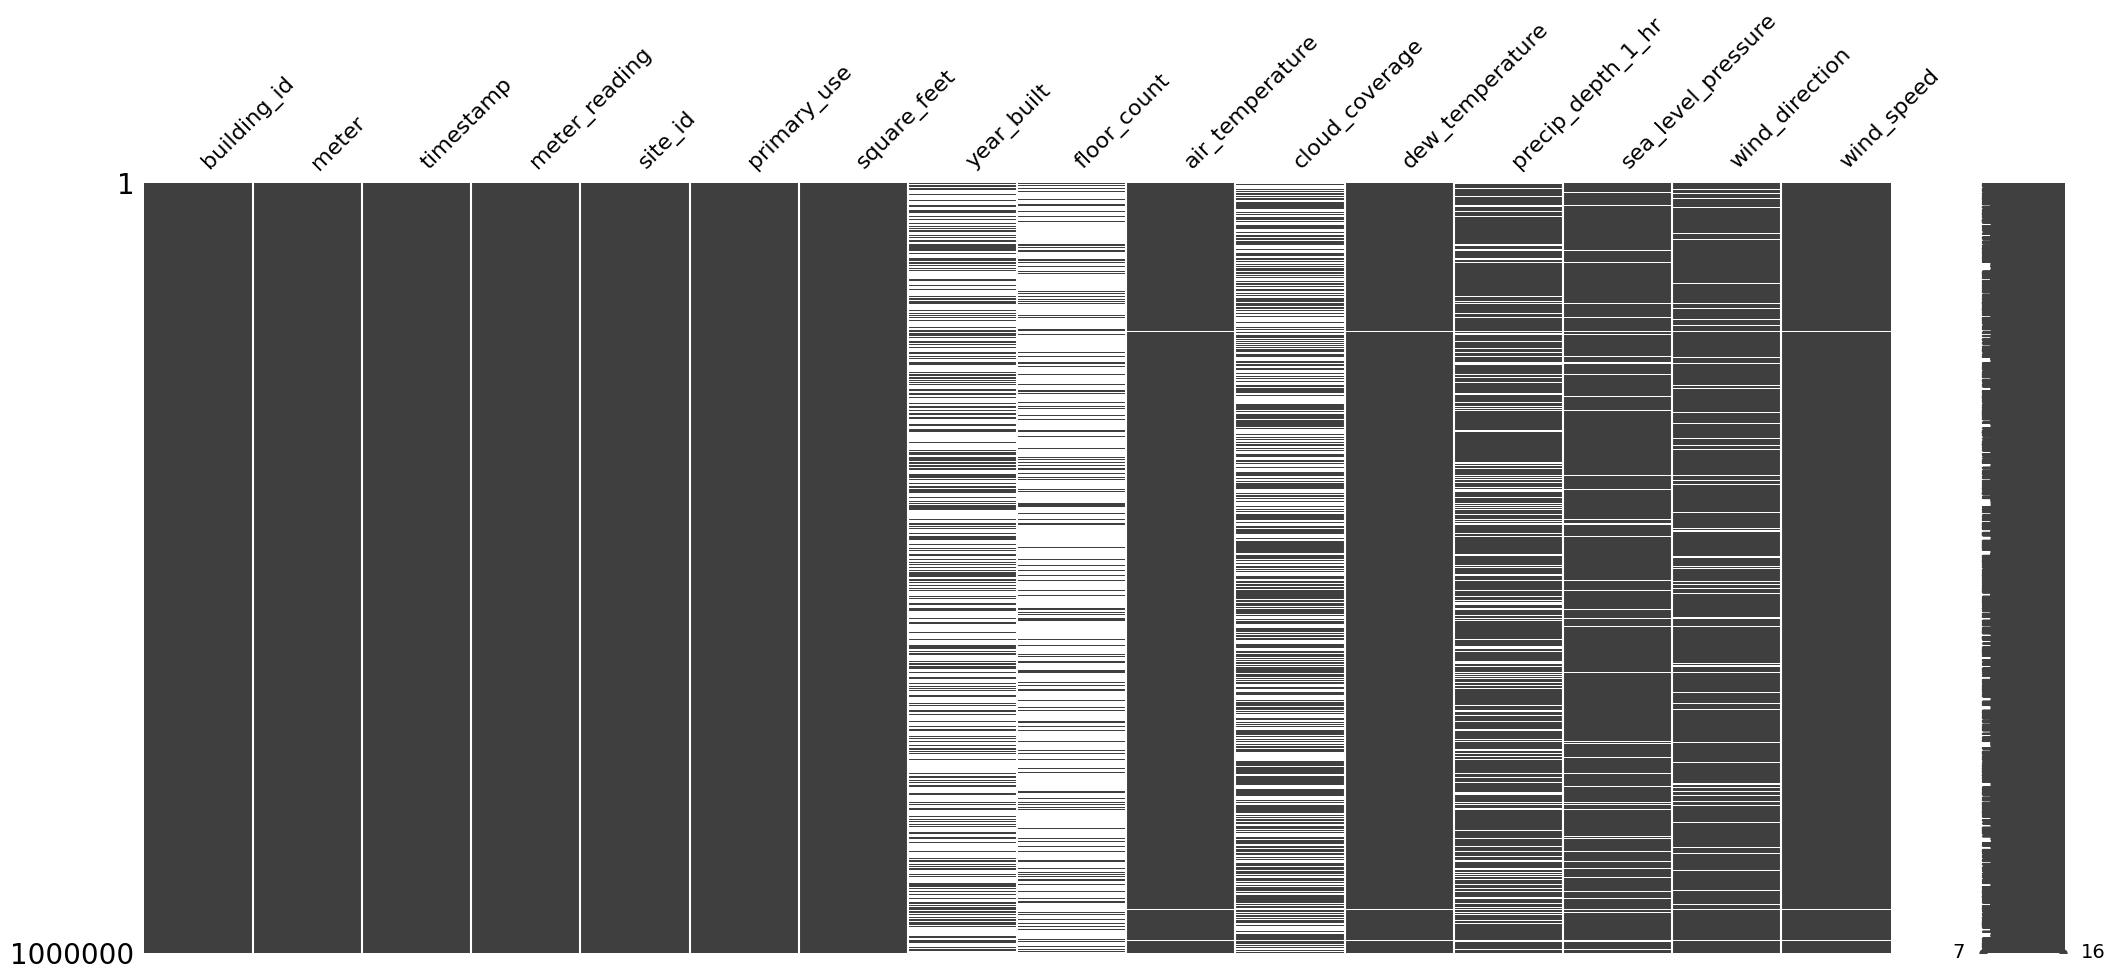

In [66]:
# visualise missing values
msno.matrix(tdfs)

year_built, floor_count, cloud coverage, precip_depth_1hr are missing a lot of data. May be worth dropping from analysis.

In [88]:
#  distribution: meter readings
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [91]:
output_notebook()

def make_plot(title, hist, edges, xlabel):
    p = figure(title=title, tools='', background_fill_color="#fafafa")
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color="#1E90FF", line_color="white", alpha=0.5)

    p.y_range.start = 0
    p.xaxis.axis_label = f'Log of {xlabel} meter reading'
    p.yaxis.axis_label = 'Probability'
    p.grid.grid_line_color="white"
    return p

temp_df = tdfs[tdfs["meter"]==0]
hist, edges = np.histogram(np.log1p(temp_df["meter_reading"].values), density=True, bins=50)
p1 = make_plot("Meter Reading Distribution - Electricity", hist, edges, "electricity")

temp_df = tdfs[tdfs["meter"]==1]
hist, edges = np.histogram(np.log1p(temp_df["meter_reading"].values), density=True, bins=50)
p2 = make_plot("Meter Reading Distribution - Chilled Water", hist, edges, 'chill water')

temp_df = tdfs[tdfs["meter"]==2]
hist, edges = np.histogram(np.log1p(temp_df["meter_reading"].values), density=True, bins=50)
p3 = make_plot("Meter Reading Distribution - Steam", hist, edges, 'steam')

temp_df = tdfs[tdfs["meter"]==3]
hist, edges = np.histogram(np.log1p(temp_df["meter_reading"].values), density=True, bins=50)
p4 = make_plot("Meter Reading Distribution - Hot Water", hist, edges, 'hot water')

show(gridplot([p1,p2,p3,p4], ncols=2, width=400, height=400, toolbar_location=None))

Loading BokehJS ...

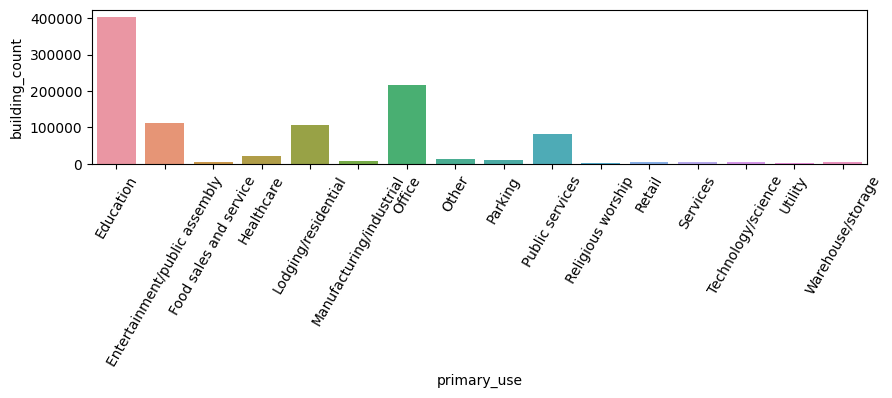

In [159]:
#  building count by primary use
prim = tdfs[['building_id', 'primary_use']].groupby(['primary_use']).count().reset_index()
prim = prim.rename({'building_id':'building_count'}, axis='columns')

plt.subplots(figsize=(10, 2))
bar = sns.barplot(
    data=prim, 
    x='primary_use', 
    y='building_count')
bar.set_xticklabels(bar.get_xticklabels(), rotation=60)

None # hide labels

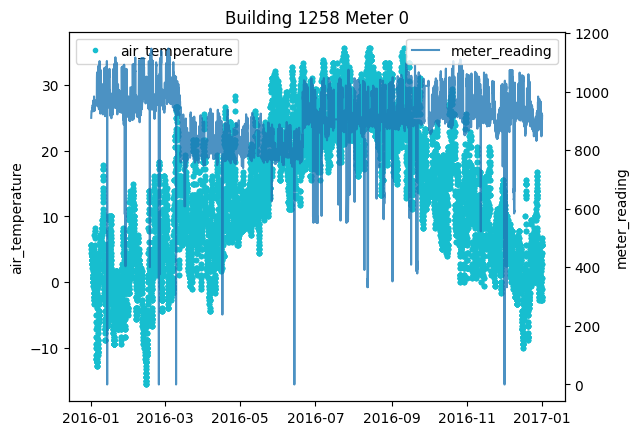

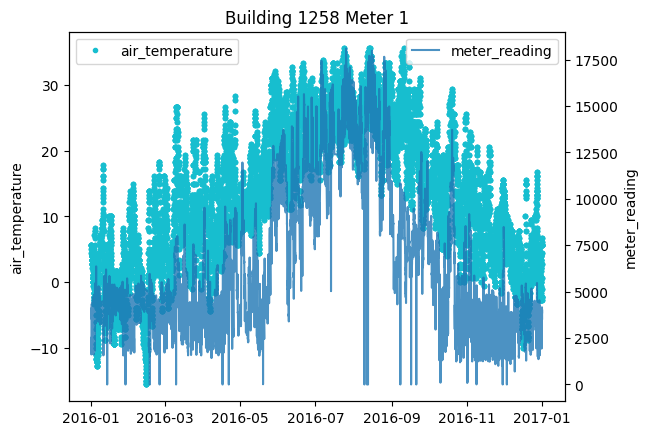

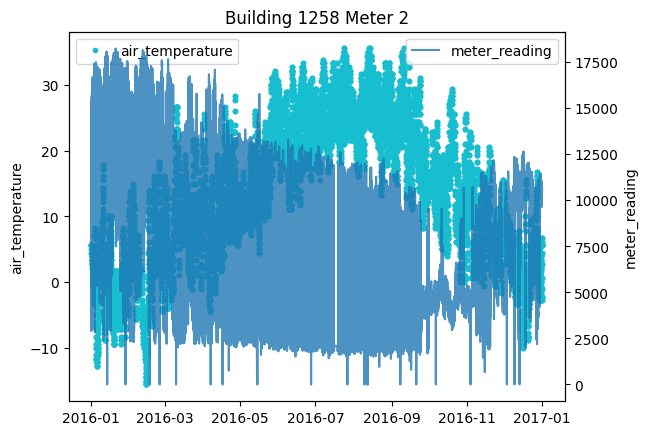

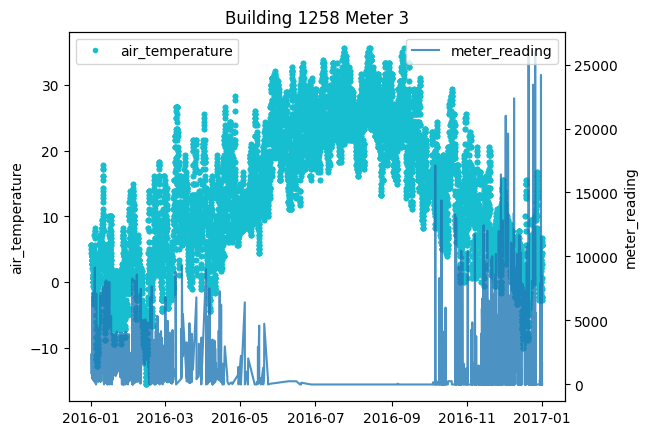

In [93]:
# example meter reading with air temperature for a building

building_id = 1258  # a building with all 4 meters
meters = train[train['building_id'] == building_id].meter.nunique()

for meter in range(meters):
    fig, ax = plt.subplots()
    plt.title(f'Building {building_id} Meter {meter}')
    ax2 = ax.twinx()
    # plot meter_reading
    idx = (train['building_id'] == building_id) & (train['meter'] == meter)
    dates = matplotlib.dates.date2num(train.loc[idx, 'timestamp'])
    ax2.plot_date(dates, train.loc[idx, 'meter_reading'], '-', label='meter_reading', alpha=0.8)
    # plot air_temperature
    dates = matplotlib.dates.date2num(train.loc[train['building_id'] == building_id, 'timestamp'])
    ax.plot_date(dates, train.loc[train['building_id'] == building_id, 'air_temperature'], '.', color='tab:cyan', label='air_temperature')
    ax.set_ylabel('air_temperature'); ax2.set_ylabel('meter_reading')
    ax.legend(loc='upper left'); ax2.legend(loc='upper right')

In [134]:
tdfs.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
3732643,119,0,2016-03-11 12:00:00,498.292999,1,Education,91149,2007.0,7.0,7.699219,NaN,3.699219,NaN,1029.0,200.0,1.000000
18956633,1094,1,2016-12-09 18:00:00,0.000000,13,Office,70852,NaN,NaN,-8.898438,6.0,-13.898438,0.0,1036.0,230.0,3.599609
6724813,1084,1,2016-05-05 14:00:00,58.476601,13,Office,122922,NaN,NaN,12.796875,2.0,-1.099609,0.0,1018.5,190.0,4.101562
1947460,1017,1,2016-02-05 07:00:00,0.000000,10,Technology/science,109263,NaN,6.0,-2.800781,NaN,-4.398438,0.0,1034.0,0.0,0.000000
3759679,1240,1,2016-03-12 00:00:00,1450.390015,14,Public services,73277,NaN,NaN,13.898438,0.0,-0.600098,0.0,1025.0,340.0,3.599609
